In [327]:
class Graph(object):
    def __init__(self, cost_matrix: list, size: int):
        self.matrix = cost_matrix
        self.rank = size

        # noinspection PyUnusedLocal
        #initialize the pheromone value: the pheromone on paths between each pair of city is initialized as the same as "1 / (size * size)"
        self.pheromone = [
            [
                1 / (size * size)
                for j in range(size)
            ]
            for i in range(size)
        ]

        # print(self.pheromone)


In [328]:

class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost


In [329]:
import random

class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                                                                                            i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [330]:
import operator

import matplotlib.pyplot as plt

def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    # noinspection PyUnusedLocal
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co')

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        # noinspection PyUnresolvedReferences
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)

    # noinspection PyTypeChecker
    plt.xlim(0, max(x) * 1.1)
    # noinspection PyTypeChecker
    plt.ylim(0, max(y) * 1.1)
    plt.show()


cost: 15601.919532918737, path: [0, 14, 13, 11, 12, 10, 22, 15, 4, 5, 6, 1, 3, 7, 8, 9, 2, 17, 16, 18, 23, 24, 19, 20, 21, 25, 27, 26, 29, 30, 28]


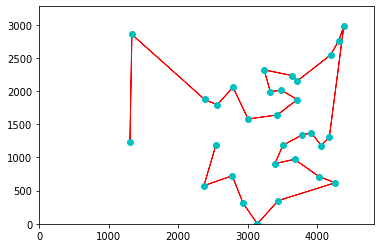

In [332]:
import math

# from aco import ACO, Graph
# from plot import plot

# used to calculate the distance between two cities
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)


def main():
    cities = []
    points = []
    index_count = 1

    # read cities from the dataset
    with open('./data/chn31.txt') as file:
        for line in file.readlines():
            city = line.split(' ')
            cities.append(dict(index = index_count, x=int(city[0]), y=int(city[1])))
            points.append((int(city[0]), int(city[1])))
            index_count += 1

    cost_matrix = []
    size = len(cities)

    # now we have the adjency list for the cities
    for i in range(size):
        row = []
        for j in range(size):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)

    # initialize the ACO attributes
    # ACO(ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int, strategy: int)
    aco = ACO(100, 100, 1.0, 10.0, 0.5, 10, 2)

    # initialize the Graph with all same 
    # Graph(cost_matrix: list, size: int)
    graph = Graph(cost_matrix, size)

    # run ACO on Graph
    path, cost = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    plot(points, path)

if __name__ == '__main__':
    main()
